# CIS6800: Project 2: YOLO

### Instructions:
* As the autograder uses the definitions for functions and classes you submit,
please do not modify the name of any function or class provided.
* This is a group assignment with one submission per group. It is expected that each member of the group will contribute to solving each question. Be sure to specify your teammates when you submit to Gradescope! Collaborating with other groups is not permitted.
* There is no single answer to most problems in deep learning, therefore the questions will often be underspecified. You need to fill in the blanks and submit a solution that solves the (practical) problem. Document the choices (hyperparameters, features, neural network architectures, etc.) you made where specified.
* All the code should be written in Python. PyTorch is required, PyTorch Lightning is recommended but not required.
* You may include any code used in previous projects.
* You are encouraged to use ChatGPT, but you need to make a summary of how you used it, and the code that you have copied from it.


## Introduction
Object detection is a fundamental task in computer vision. The problem of object recognition essentially consists of first localizing the object and then classifying it with a semantic label. In recent deep learning based methods, YOLO is an extremely fast real time multi object detection algorithm.  
  
<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW2/fig2_1.png"/></div>
<center>Figure 1: This is a demo of what object detection does. The color indicates different semantic class.</center>  
  
In this project, we provide 10K street scene images with correponding labels as training data. The image dimension is $128 \times 128 \times 3$, and the labels include the semantic class and the bounding box corresponding to each object in the image. Note that a small portion of these ground-truth labels are not a little bit noisy and the quantity of the training set is not very large, so we do not expect you to learn a super robust object detector.

## Data Preprocessing
For this section, you will need to write code to preprocess the ground truth labels for the YOLO algorithm. The
labels are provided in the "label" folder. The format of the labels are (class, $x_1$, $y_1$, $x_2$, $y_2$), where $x_1$, $y_1$ are the top left corner of the bounding box and $x_2$, $y_2$ are the bottom right corner of the bounding box.  
  
<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW2/fig2_2.png"/></div>
<center>Figure 2: This figure demonstrates the format of ground-truth labels that YOLO algorithm requires.</center>  
  
For each image, you are required to convert the provided labels into the $8 \times 8 \times 8$ ground truth matrix, which has the same dimension as the output of YOLO detection network. The instructions of this conversion is as follows:
* We consider a $16 \times 16$ image patch as a grid cell and thus divide the full image into $8 \times 8$ patches in the 2D spatial dimension. In the output activation space, one grid cell represents one 16x16 image patch with corresponding aligned locations.
* For simplified YOLO, we only use one anchor box, where we assume the anchor size is the same as the grid cell size. If the center of an object falls into a grid cell, that grid cell is responsible for detecting that object. This means that there is only one anchor for each object instance.
* For each anchor, there are 8 channels, which encode Pr(Objectness), $x$, $y$, $w$, $h$, P(class=pedestrian),  P(class=traffic light), and P(class=car).
* The Pr(Objectness) is the probability of whether this anchor is an object or background. When assigning the ground-truth for this value, "1" indicates object and "0" indicates background.
* The channels 2-5, $x$, $y$ coordinates represent the center of the box relative to the bounds of the grid cell; $w$, $h$ is relative to the image width and height.
* In channels 6-8, you need to convert the ground truth semantic label of each object into one-hot coding for each anchor boxes.
* Note that if the anchor box does not have any object (Pr=0), you donâ€™t need to assign any values to channels 2-8, since we will not use them during training.
* The dimensions are ordered (channels, x, y).

## Model Architecture
You are required to implement the model architecture using the following parameters. This model takes input with dimension of $128 \times 128 \times 3$ and outputs an activation with dimension of $8 \times 8 \times 8$.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW2/fig2_3.png"/></div>
<center>Figure 3: This figure demonstrates how to compute IoU.</center>

| Layer | Hyperparameters |
| :-: | :-: |
| conv1 | Kernel size $= 4 \times 4 \times 32$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv2 | Kernel size $= 4 \times 4 \times 64$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv3 | Kernel size $= 4 \times 4 \times 128$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv4 | Kernel size $= 4 \times 4 \times 256$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv5 | Kernel size $= 4 \times 4 \times 512$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv6 | Kernel size $= 4 \times 4 \times 1024$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| transposed_conv7 | Kernel size $= 4 \times 4 \times 256$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| transposed_conv8 | Kernel size $= 4 \times 4 \times 64$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv9 | Kernel size $= 3 \times 3 \times 8$, stride $=1$, pad $=1$. |


## Training Details
During training, the localization and classification errors are optimized jointly. The loss function is shown
as below.  $i$ indicates number of grid cells and $j$ indicates number of anchor boxes at each grid cell. In our
case, there is only one anchor box at each grid cell and $B = 1$.

$$ \text{Loss} =
{\lambda_\text{coord} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{obj} \left[{\left(x_i - \hat{x}_i\right)}^2 + {\left(y_i - \hat{y}_i\right)}^2\right]} +
{\lambda_\text{coord} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{obj} \left[{\left(\sqrt{w_i} - \sqrt{\hat{w}_i}\right)}^2 + {\left(\sqrt{h_i} - \sqrt{\hat{h}_i}\right)}^2\right]} +
{\sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{obj} \left(C_i - \hat{C}_i\right)^2} +
{\lambda_\text{no obj} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{no obj} \left(C_i - \hat{C}_i\right)^2} +
{\sum_{i=0}^{S^2} \mathbb{1}_{ij}^\text{obj} \sum_{c\, \in\, \text{classes}} \left(p_i(c) - \hat{p}_i(c)\right)^2}$$

* In our case there is only one anchor box at each grid, hence $B = 1$.
* $S^2 =$ total number of grid cells.
* $\mathbb{1}_{ij}^\text{obj} = 1$ if an object appears in grid cell $i$ and 0 otherwise.
* $\mathbb{1}_{ij}^\text{no obj}$ is the compliment of $\mathbb{1}_{ij}^\text{obj}$.
* $\hat{C}_i =$ Box confidence score $=$ Pr(box contains object) $\times$ IoU
* IoU $=$ Intersection over union between the predicted and the ground truth.
* $\hat{p}_i(c) =$ conditional class probability of class $c$ in cell $i$.

$\lambda_\text{coord}$ and and $\lambda_\text{no obj}$ are two hyperparameters for coordinate predictions and non-objectness classification. We set $\lambda_\text{coord} = 5$ and and $\lambda_\text{no obj} = 0.5$.

Each grid cell predicts 1 bounding box, confidence score for those boxes and class conditional probabilities.

The confidence Score reflects the degree of confidence that the box contains an object and how accurate the box is. If no object exists in the cell then the confidence score should be 0 else the confidence score should be equal to the IOU between the predicted box and the ground truth box.

During training, you can set learning rate of 10e-3 using Adam optimizer with default beta 1 and beta 2. You are encourage to adaptively adjust learning rate during training to see if the model will converge better. You should also visualize the loss over training iterations. You will need to decide at the iteration to stop training based on the loss visualization. (At least 20 epochs of training is required.)

## Post-Processing
During inference, the network is going to predict lots of overlapping redundant bounding boxes. To eliminate the redundant boxes, there are basically two steps:

1. Get rid of predicted boxes with low objectness probability (Pr $< 0.6$).
2. For each class, calculate the IoU for all the bounding boxes and cluster boxes with IoU > 0.5 as a group. For each group, find the one with highest Pr and suppress the other boxes. This is referred as non-max suppression.

To evaluate the performance of your YOLO implementation, compute the mean Average Precision (mAP) of inference. Predicted bounding boxes are a match with ground truth bounding boxes if they share the same label and have an IoU with the ground truth bounding box of greater than 0.5. These matches can be used to calculate a precision/recall curve for each class. The Average Precision for a class is the area under this curve. The mean of these Average Precision values over all the classes in inference gives the mean Average Precision of your network.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW2/fig2_4.png"/></div>
<center>Figure 4: This figure demonstrates post-process of how to get rid of redundant bounding box.</center>

## Code

In [26]:
%pip install pytorch_lightning -q

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import pytorch_lightning as pl
import pytorch_lightning.loggers as pl_loggers
import pytorch_lightning.callbacks as pl_callbacks
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0"  if use_cuda else "cpu")
print(device)
seed = 17
torch.manual_seed(seed);

cuda:0


In [27]:
# download the data
# if this fails, you can download manually and upload to colab
# manual download link: https://drive.google.com/file/d/1NzN5m3aaQ5XpSEV6toRZiUAGvSh4Ojs4/view?usp=sharing
# !wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1NzN5m3aaQ5XpSEV6toRZiUAGvSh4Ojs4' -O labels.npz
# !wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1MT-J-hgix3BX7HpUumNQiX5J-By47vt1' -O images.npz

In [28]:
# Use this function to import the provided data files
def load_data(file_name):
    return np.load(file_name, allow_pickle=True, encoding='latin1')['arr_0']

import traceback
try:
  images = load_data('images.npz')
  raw_labels = load_data('labels.npz')
except Exception as e:
  print(e)
  traceback.print_exc()
  print("load failed, maybe manual download")

In [29]:
# This function should compute the 8X8X8 label from the raw labels for the corresponding image.
def process_labels(raw_labels):
    """
    Convert raw labels to 8x8x8 YOLO format.
    Each image gets a grid of shape (8, 8, 8) where dimensions are (channels, x, y).
    """
    IMG_W = IMG_H = 128
    S = 8                      # grid size
    CELL = IMG_W // S          # 16 pixels per cell
    NUM_CH = 8

    # Map class to channel indexes (5..7)
    class_to_idx = {
        0: 0, 1: 1, 2: 2,
        "pedestrian": 0,
        "traffic light": 1,
        "traffic_light": 1,
        "traffic-light": 1,
        "car": 2,
    }

    def ensure_array(x):
        """Ensure input is a proper numpy array."""
        if x is None:
            return np.zeros((0, 5), dtype=np.float32)
        arr = np.asarray(x)
        if arr.size == 0:
            return np.zeros((0, 5), dtype=np.float32)
        # Handle single bounding box case
        if arr.ndim == 1 and arr.size >= 5:
            arr = arr[None, :]
        if arr.ndim != 2 or arr.shape[1] < 5:
            return np.zeros((0, 5), dtype=np.float32)
        return arr.astype(np.float32)

    N = len(raw_labels)
    labels = np.zeros((N, NUM_CH, S, S), dtype=np.float32)

    for i, boxes in enumerate(raw_labels):
        boxes = ensure_array(boxes)

        for box in boxes:
            if len(box) < 5:
                continue

            cls_raw, x1, y1, x2, y2 = box[:5]

            # Clip coordinates to image bounds
            x1 = float(np.clip(x1, 0, IMG_W))
            y1 = float(np.clip(y1, 0, IMG_H))
            x2 = float(np.clip(x2, 0, IMG_W))
            y2 = float(np.clip(y2, 0, IMG_H))

            if x2 <= x1 or y2 <= y1:
                continue  # Skip invalid boxes

            # Center and size in absolute pixels
            cx = 0.5 * (x1 + x2)
            cy = 0.5 * (y1 + y2)
            w = x2 - x1
            h = y2 - y1

            # Which cell contains the center
            gx = int(cx // CELL)
            gy = int(cy // CELL)
            gx = np.clip(gx, 0, S - 1)
            gy = np.clip(gy, 0, S - 1)

            # Set objectness
            labels[i, 0, gx, gy] = 1.0

            # x, y relative to cell bounds [0, 1]
            cx_in_cell = cx - gx * CELL
            cy_in_cell = cy - gy * CELL
            x_rel = cx_in_cell / CELL
            y_rel = cy_in_cell / CELL

            # Ensure relative coordinates are in [0, 1]
            x_rel = np.clip(x_rel, 0.0, 1.0)
            y_rel = np.clip(y_rel, 0.0, 1.0)

            # w, h relative to image dimensions
            w_rel = w / IMG_W
            h_rel = h / IMG_H
            w_rel = np.clip(w_rel, 0.0, 1.0)
            h_rel = np.clip(h_rel, 0.0, 1.0)

            labels[i, 1, gx, gy] = x_rel
            labels[i, 2, gx, gy] = y_rel
            labels[i, 3, gx, gy] = w_rel
            labels[i, 4, gx, gy] = h_rel

            # Class one-hot encoding in channels 5..7
            # Map class label to index
            if isinstance(cls_raw, (int, float)):
                cls_idx = int(cls_raw)
            else:
                cls_idx = class_to_idx.get(cls_raw, -1)

            # Clear previous class assignments for this cell
            labels[i, 5:8, gx, gy] = 0.0

            # Set one-hot encoding if valid class
            if cls_idx in [0, 1, 2]:
                labels[i, 5 + cls_idx, gx, gy] = 1.0

    return labels  # [N_image, 8, 8, 8]

In [30]:
# This function should perform the inverse operation of process_labels().
def reconstruct_raw_labels(labels, img_dim=128, include_score=False):
    # labels: [N_image, 8, 8, 8]
    labels = np.asarray(labels)
    assert labels.ndim == 4 and labels.shape[1:] == (8, 8, 8), \
        "labels must be [N_image, 8, 8, 8] with (channels, x, y) ordering per image."

    N = labels.shape[0]
    S = 8
    CELL = img_dim // S

    out = []
    # threshold to decide a cell has an object; 0.5 matches ground-truth 0/1,
    # but works for predictions too.
    OBJ_THRESH = 0.5

    for i in range(N):
        li = labels[i]  # shape (8, 8, 8)
        obj = li[0]     # (x, y)
        xs  = li[1]
        ys  = li[2]
        ws  = li[3]
        hs  = li[4]
        cls_block = li[5:8]  # (3, x, y)

        boxes = []
        for gx in range(S):
            for gy in range(S):
                pr = float(obj[gx, gy])
                if pr < OBJ_THRESH:
                    continue

                x_rel = float(xs[gx, gy])
                y_rel = float(ys[gx, gy])
                w_rel = float(ws[gx, gy])
                h_rel = float(hs[gx, gy])

                # decode center: absolute px
                cx = (gx + x_rel) * CELL
                cy = (gy + y_rel) * CELL

                # decode size: absolute px
                w = w_rel * img_dim
                h = h_rel * img_dim
                if w <= 0 or h <= 0:
                    continue

                x1 = cx - 0.5 * w
                y1 = cy - 0.5 * h
                x2 = cx + 0.5 * w
                y2 = cy + 0.5 * h

                # clip to image
                x1 = float(np.clip(x1, 0, img_dim))
                y1 = float(np.clip(y1, 0, img_dim))
                x2 = float(np.clip(x2, 0, img_dim))
                y2 = float(np.clip(y2, 0, img_dim))
                if x2 <= x1 or y2 <= y1:
                    continue

                # class id from one-hot/probs: channels 5..7
                cls_probs = cls_block[:, gx, gy]
                cls_id = int(np.argmax(cls_probs))  # 0: pedestrian, 1: traffic light, 2: car

                if include_score:
                    # Score = objectness (Pr) or for conficdence we can use
                    # pr * float(np.max(cls_probs)) instead.
                    boxes.append([cls_id, pr, x1, y1, x2, y2])
                else:
                    boxes.append([cls_id, x1, y1, x2, y2])

        if boxes:
            boxes = np.asarray(boxes, dtype=np.float32)
        else:
            boxes = np.zeros((0, 6 if include_score else 5), dtype=np.float32)

        out.append(boxes)

    return out

In [ ]:
def yolo_loss(
    output: torch.Tensor,
    target: torch.Tensor,
    img_dim: float = 128.0,
    S: int = 8,
    lambda_coord: float = 5.0,
    lambda_noobj: float = 0.5,
    eps: float = 1e-9,
) -> torch.Tensor:


    # ---- Normalize shapes to (B,H,W,C) ----
    if output.ndim == 4 and output.shape[1] == 8:          # (B,C,H,W)
        pred_l = output.permute(0, 2, 3, 1).contiguous()
        tgt_l  = target.permute(0, 2, 3, 1).contiguous()
    else:
        raise ValueError(f"unsupported shapes for pred/target: {output.shape} vs {target.shape}")

    B, H, W, C = pred_l.shape
    assert C == 8, f"Expected 8 channels (C,x,y,w,h,3 classes), got {C}"
    device = pred_l.device

    # ---- Unpack ----
    C_pred_raw = pred_l[..., 0]                  # Raw logits for confidence
    C_pred = torch.sigmoid(C_pred_raw)           # CRITICAL: Apply sigmoid to match target range [0,1]
    px, py = pred_l[..., 1], pred_l[..., 2]      # cell-relative center offsets in [0,1]
    pw, ph = pred_l[..., 3], pred_l[..., 4]      # image-relative sizes in [0,1]
    p_cls  = pred_l[..., 5:8]                    # class scores (logits)

    # Targets
    obj   = tgt_l[..., 0]                        # use mask as provided (0 or 1)
    noobj = 1.0 - obj
    tx, ty = tgt_l[..., 1], tgt_l[..., 2]
    tw, th = tgt_l[..., 3], tgt_l[..., 4]
    t_cls  = tgt_l[..., 5:8]

    # ---- Coordinate loss (obj cells), sqrt on w,h ----
    xy_loss = ((px - tx) ** 2 + (py - ty) ** 2) * obj
    sqrt_pw = torch.sqrt(torch.clamp(pw, min=eps))
    sqrt_ph = torch.sqrt(torch.clamp(ph, min=eps))
    sqrt_tw = torch.sqrt(torch.clamp(tw, min=eps))
    sqrt_th = torch.sqrt(torch.clamp(th, min=eps))
    wh_loss = ((sqrt_pw - sqrt_tw) ** 2 + (sqrt_ph - sqrt_th) ** 2) * obj
    coord_loss = lambda_coord * (xy_loss.sum() + wh_loss.sum())

    # ---- IoU for Ĉ = 1_obj * IoU(pred, gt) ----
    CELL = img_dim / S
    iy, ix = torch.meshgrid(
        torch.arange(H, device=device),
        torch.arange(W, device=device),
        indexing='ij'
    )
    ix = ix.view(1, H, W).float()
    iy = iy.view(1, H, W).float()

    # Pred absolute box
    cxp = (ix + px) * CELL
    cyp = (iy + py) * CELL
    wp  = pw * img_dim
    hp  = ph * img_dim
    x1p = cxp - 0.5 * wp; y1p = cyp - 0.5 * hp
    x2p = cxp + 0.5 * wp; y2p = cyp + 0.5 * hp

    # GT absolute box
    cxt = (ix + tx) * CELL
    cyt = (iy + ty) * CELL
    wt  = tw * img_dim
    ht  = th * img_dim
    x1t = cxt - 0.5 * wt; y1t = cyt - 0.5 * ht
    x2t = cxt + 0.5 * wt; y2t = cyt + 0.5 * ht

    # IoU
    ix1 = torch.maximum(x1p, x1t); iy1 = torch.maximum(y1p, y1t)
    ix2 = torch.minimum(x2p, x2t); iy2 = torch.minimum(y2p, y2t)
    iw  = torch.clamp(ix2 - ix1, min=0.0)
    ih  = torch.clamp(iy2 - iy1, min=0.0)
    inter = iw * ih
    ap = torch.clamp(x2p - x1p, min=0.0) * torch.clamp(y2p - y1p, min=0.0)
    at = torch.clamp(x2t - x1t, min=0.0) * torch.clamp(y2t - y1t, min=0.0)
    iou = inter / (ap + at - inter + eps)

    # ---- Confidence/objectness loss ----
    C_tgt = obj * iou                              # Ĉ = 1_obj * IoU
    obj_loss   = ((C_pred - C_tgt) ** 2 * obj).sum()
    noobj_loss = ((C_pred - 0.0) ** 2 * noobj).sum() * lambda_noobj

    # ---- Class loss (obj cells only), no per-class weights in the formula ----
    p_cls_prob = p_cls
    cls_loss = (((p_cls_prob - t_cls) ** 2) * obj.unsqueeze(-1)).sum()

    total = (coord_loss + obj_loss + noobj_loss + cls_loss) / B
    return total

# Part B

In [ ]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.optim import Adam
class YOLO(pl.LightningModule):

    def __init__(self, img_dim=128, grid_size=8, lr=1e-2):
        super().__init__()
        self.save_hyperparameters()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3,   32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
        )  # 128 -> 64
        self.conv2 = nn.Sequential(
            nn.Conv2d(32,  64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )  # 64 -> 32
        self.conv3 = nn.Sequential(
            nn.Conv2d(64,  128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )  # 32 -> 16
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )  # 16 -> 8
        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )  # 8 -> 4
        self.conv6 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
        )  # 4 -> 2

        # ---- Decoder ----
        self.deconv7 = nn.Sequential(
            nn.ConvTranspose2d(1024, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )  # 2 -> 4
        self.deconv8 = nn.Sequential(
            nn.ConvTranspose2d(256,  64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )  # 4 -> 8

        # prediction head (enable bias for proper initialization)
        self.conv9 = nn.Conv2d(64, 8, kernel_size=3, stride=1, padding=1, bias=True)  # 8x8x8

        self._init_weights()

    def _init_weights(self):
        # Kaiming normal for convs; zero BN bias
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if getattr(m, "bias", None) is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
        
        # Special init for final prediction layer (conv9)
        # Initialize objectness bias to -4.6 so sigmoid(−4.6) ≈ 0.01 (sparse objects)
        nn.init.normal_(self.conv9.weight, mean=0, std=0.01)
        nn.init.constant_(self.conv9.bias[0], -4.6)  # objectness channel
        nn.init.zeros_(self.conv9.bias[1:5])          # x,y,w,h channels
        nn.init.zeros_(self.conv9.bias[5:8])          # class channels

    def forward(self, x):
        x = self.conv1(x)   # 64
        x = self.conv2(x)   # 32
        x = self.conv3(x)   # 16
        x = self.conv4(x)   # 8
        x = self.conv5(x)   # 4
        x = self.conv6(x)   # 2
        x = self.deconv7(x) # 4
        x = self.deconv8(x) # 8
        out = self.conv9(x) # [B, 8, 8, 8]
        # FIXME? need a sigmoid here? the values should all be 0-1

        C_raw = out[:, 0:1]
        xy_raw  = out[:, 1:3]
        wh_raw  = out[:, 3:5]
        cls_log = out[:, 5:8]

        C   = torch.sigmoid(C_raw)
        xy  = torch.sigmoid(xy_raw)     # in-cell offsets ∈ [0,1]
        wh  = torch.sigmoid(wh_raw)

        out = torch.cat([C, xy, wh, cls_log], dim=1)

        return out

    def training_step(self, batch, batch_idx):
        images, targets = batch
        # Here I changed targets (C, x, y) -> (C, y, x) to match model output
        # FIXME Kidus commented out permute: new loss assumes the input was B=0 C=1 H=2 W=3 did permute(0, 2, 3, 1) internally to get B=0 H=2 W=3 C=1
        targets = targets.permute(0, 1, 3, 2)
        preds = self.forward(images)
        loss = yolo_loss(preds, targets, img_dim=self.hparams.img_dim, S=self.hparams.grid_size)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, batch_size=images.size(0))
        return loss

    def validation_step(self, batch, batch_idx):
        images, targets = batch
        # Again as above: targets (C, x, y) -> (C, y, x) to match model output
        # FIXME Kidus commented out permute : new loss assumes the input was B=0 C=1 H=2 W=3 did permute(0, 2, 3, 1) internally to get B=0 H=2 W=3 C=1
        targets = targets.permute(0, 1, 3, 2)
        preds = self.forward(images)
        val_loss = yolo_loss(preds, targets, img_dim=self.hparams.img_dim, S=self.hparams.grid_size)
        self.log("val_loss", val_loss, on_step=False, on_epoch=True, prog_bar=True, batch_size=images.size(0))
        return val_loss
    def configure_optimizers(self):
        opt = Adam(self.parameters(), lr=self.hparams.lr, betas=(0.9, 0.999))
        # Add learning rate scheduler to reduce LR when loss plateaus
        scheduler = {
            'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=5, verbose=True),
            'monitor': 'train_loss_epoch',
            'interval': 'epoch',
            'frequency': 1
        }
        return {'optimizer': opt, 'lr_scheduler': scheduler}

In [33]:
def _iou_xyxy(a, b):
    """Compute IoU between two [x1,y1,x2,y2] boxes."""
    ax1, ay1, ax2, ay2 = a
    bx1, by1, bx2, by2 = b
    ix1 = max(ax1, bx1)
    iy1 = max(ay1, by1)
    ix2 = min(ax2, bx2)
    iy2 = min(ay2, by2)
    iw = max(0.0, ix2 - ix1)
    ih = max(0.0, iy2 - iy1)
    inter = iw * ih
    area_a = max(0.0, ax2 - ax1) * max(0.0, ay2 - ay1)
    area_b = max(0.0, bx2 - bx1) * max(0.0, by2 - by1)
    denom = area_a + area_b - inter
    return inter / denom if denom > 0 else 0.0

def low_confidence_suppression(label, thresh=0.6):
    if label is None:
        return np.zeros((0, 6), dtype=np.float32)

    arr = np.asarray(label)
    if arr.size == 0:
        return arr

    if arr.shape[1] < 6:
        # No score column to threshold on; return as-is.
        return arr

    keep = arr[:, 1] >= float(thresh)
    return arr[keep]

def non_max_suppression(label, iou_thresh=0.5):
   """
    Per-class NMS with IoU thresholding (keep highest-score box in each cluster).
    arguments
        label: np.ndarray shape (N_box, 6) as [cls, score, x1, y1, x2, y2].
              if shape is 5 a dummy var is returned of 1.0
        iou_thresh: suppress boxes with IoU > iou_thresh (default 0.5).
        return
        np.ndarray of alive boxes in the same column format as input.
    """
   if label is None:
       return np.zeros((0, 6), dtype=np.float32)

   boxes = np.asarray(label, dtype=np.float32)
   if boxes.size == 0:
       return boxes

   has_score = (boxes.shape[1] >= 6)
   if not has_score:

       ones = np.ones((boxes.shape[0], 1), dtype=np.float32)
       boxes = np.concatenate([boxes[:, :1], ones, boxes[:, 1:]], axis=1)

   kept = []

   classes = np.unique(boxes[:, 0].astype(np.int32))
   for c in classes:
       cls_mask = boxes[:, 0].astype(np.int32) == c
       cls_boxes = boxes[cls_mask]
       if cls_boxes.shape[0] == 0:
           continue
       order = np.argsort(-cls_boxes[:, 1])
       cls_boxes = cls_boxes[order]

       while cls_boxes.shape[0] > 0:
           top = cls_boxes[0]
           kept.append(top)
           if cls_boxes.shape[0] == 1:
               break
           rest = cls_boxes[1:]
           ious = np.array([_iou_xyxy(top[2:6], b[2:6]) for b in rest], dtype=np.float32)
           keep_mask = ious <= float(iou_thresh)
           cls_boxes = rest[keep_mask]

   kept = np.stack(kept, axis=0) if kept else np.zeros((0, boxes.shape[1]), dtype=np.float32)
   if not has_score:
       kept = np.concatenate([kept[:, :1], kept[:, 2:]], axis=1)
   return kept

In [34]:
import numpy as np

# Kidus: not sure why we had this function similar to _iou_xyxy_ so I am removing

# def _iou_xyxy_np(a, b):
#     ax1, ay1, ax2, ay2 = a
#     bx1, by1, bx2, by2 = b
#     ix1, iy1 = max(ax1, bx1), max(ay1, by1)
#     ix2, iy2 = min(ax2, bx2), min(ay2, by2)
#     iw, ih = max(0.0, ix2 - ix1), max(0.0, iy2 - iy1)
#     inter = iw * ih
#     area_a = max(0.0, ax2 - ax1) * max(0.0, ay2 - ay1)
#     area_b = max(0.0, bx2 - bx1) * max(0.0, by2 - by1)
#     denom = area_a + area_b - inter
#     return inter / denom if denom > 0 else 0.0

def precision_recall_curve(predictions, targets, target_class, iou_thresh=0.5):
    gt_by_img = []
    total_gt = 0
    for t in targets:
        t = np.asarray(t) if t is not None else np.zeros((0,5), np.float32)
        m = t.shape[0]
        if m == 0:
            gt_by_img.append({"boxes": np.zeros((0,4), np.float32),
                              "matched": np.zeros((0,), dtype=bool)})
            continue
        mask = (t[:,0].astype(int) == int(target_class))
        boxes = t[mask][:,1:5].astype(np.float32)
        gt_by_img.append({"boxes": boxes, "matched": np.zeros((boxes.shape[0],), dtype=bool)})
        total_gt += boxes.shape[0]

    # collect all preds of this class across images
    all_preds = []
    for i, p in enumerate(predictions):
        p = np.asarray(p) if p is not None else np.zeros((0,6), np.float32)
        if p.shape[0] == 0:
            continue
        mask = (p[:,0].astype(int) == int(target_class))
        if not np.any(mask):
            continue
        sel = p[mask][:,1:7]
        for row in sel:
            score = float(row[0])
            all_preds.append((score, i, row[1:5].astype(np.float32)))


    if total_gt == 0:
        return np.array([0.0]), np.array([1.0])

    # sort predictions by score desc
    all_preds.sort(key=lambda x: -x[0])

    tps, fps = [], []
    for score, img_idx, box in all_preds:
        g = gt_by_img[img_idx]
        g_boxes = g["boxes"]
        g_matched = g["matched"]

        best_iou, best_j = 0.0, -1
        for j in range(g_boxes.shape[0]):
            if g_matched[j]:
                continue
            iou = _iou_xyxy(box, g_boxes[j])
            if iou > best_iou:
                best_iou, best_j = iou, j

        if best_iou >= iou_thresh and best_j >= 0:
            tps.append(1.0); fps.append(0.0)
            g_matched[best_j] = True  # lock that GT
        else:
            tps.append(0.0); fps.append(1.0)

    tps = np.cumsum(np.array(tps))
    fps = np.cumsum(np.array(fps))
    recalls = tps / max(1, total_gt)
    precisions = tps / np.maximum(tps + fps, 1e-9)


    mrec = np.concatenate(([0.0], recalls, [1.0]))
    mpre = np.concatenate(([0.0], precisions, [0.0]))
    for i in range(mpre.size - 1, 0, -1):
        mpre[i-1] = max(mpre[i-1], mpre[i])


    return mrec[1:-1], mpre[1:-1]

def average_precision(predictions, targets, target_class, iou_thresh=0.5):
    r, p = precision_recall_curve(predictions, targets, target_class, iou_thresh=iou_thresh)
    if r.size == 0:
        return 0.0

    ap = float(np.trapz(p, r))
    return ap

def mean_average_precision(predictions, targets, iou_thresh=0.5, classes=(0,1,2)):
    """Mean AP over provided classes. Skips classes with no GT to avoid NaNs."""
    aps = []

    gt_classes = set()
    for t in targets:
        t = np.asarray(t) if t is not None else np.zeros((0,5), np.float32)
        if t.size:
            gt_classes.update(t[:,0].astype(int).tolist())

    for c in classes:
        if c not in gt_classes:
            continue
        ap = average_precision(predictions, targets, c, iou_thresh=iou_thresh)
        aps.append(ap)
    return float(np.mean(aps)) if aps else 0.0

## Instructions and Evaluation

This project is divided into the following parts:

1. Choose an image that has all three classes present (the image has a car, a person, and a traffic light).
  1. Show the chosen image with ground truth bounding boxes visualized. Use green bounding boxes around cars, red bounding boxes around pedestrians, and blue bounding boxes around traffic lights. See Figure 1 as an example of what this visualization should look like. (3%)
  2. Convert the image labels to an 8x8x8 representation, and show each channel of the processed labels in the report. Label the visualization of each channel with the associated channel number and visualized value. Example: "Channel 1: Pr(Objectness)". (5%)
  3. To test your data preprocessing code, convert your 8x8x8 representation for this step back to the original input data and ensure that your image with recomputed bounding boxes looks the same as the input. Show this image with bounding box visualizations in your report. This test code for data preprocessing will also be needed in the inference step. (2%)

Selected image index with all three classes: 8


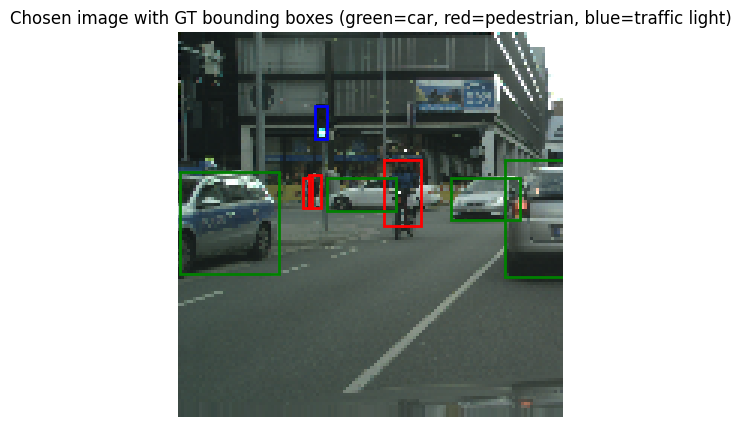

In [35]:
# Show the chosen image with ground truth bounding boxes visualized.
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def _norm_class_id(c):
    """Map label entry to {0:pedestrian, 1:traffic light, 2:car}."""
    if isinstance(c, (np.floating, float)):
        c = int(c)
    if isinstance(c, (np.integer, int)):
        return c
    s = str(c).lower().replace("-", " ").strip()
    if s in {"pedestrian", "person"}: return 0
    if s in {"traffic light", "trafficlight"}: return 1
    if s in {"car", "vehicle"}: return 2
    raise ValueError(f"Unrecognized class label: {c}")

def _draw_boxes(ax, boxes, class_to_color):
    for (cls, x1, y1, x2, y2) in boxes:
        cls = _norm_class_id(cls)
        color = class_to_color[cls]
        w, h = (x2 - x1), (y2 - y1)
        rect = Rectangle((x1, y1), w, h, fill=False, linewidth=2, edgecolor=color)
        ax.add_patch(rect)

three_class_idx = None
for i, boxes in enumerate(raw_labels):
    arr = np.asarray(boxes)
    if arr.size == 0:
        continue
    try:
        cls_set = set(_norm_class_id(c) for c in arr[:, 0])
        if {0, 1, 2}.issubset(cls_set):
            three_class_idx = i
            break
    except Exception:
        continue

assert three_class_idx is not None, "Could not find an image containing all three classes."

SELECT_IDX = three_class_idx
print(f"Selected image index with all three classes: {SELECT_IDX}")


img = images[SELECT_IDX]
if img.ndim == 3 and img.shape[0] == 3:
    img = np.transpose(img, (1, 2, 0))
img = np.clip(img, 0, 255).astype(np.uint8)

gt_boxes = np.asarray(raw_labels[SELECT_IDX], dtype=np.float32)

class_to_color = {0: "red", 1: "blue", 2: "green"}

plt.figure(figsize=(5,5))
ax = plt.gca()
ax.imshow(img)
_draw_boxes(ax, gt_boxes, class_to_color)
ax.set_title("Chosen image with GT bounding boxes (green=car, red=pedestrian, blue=traffic light)")
ax.axis("off")
plt.show()


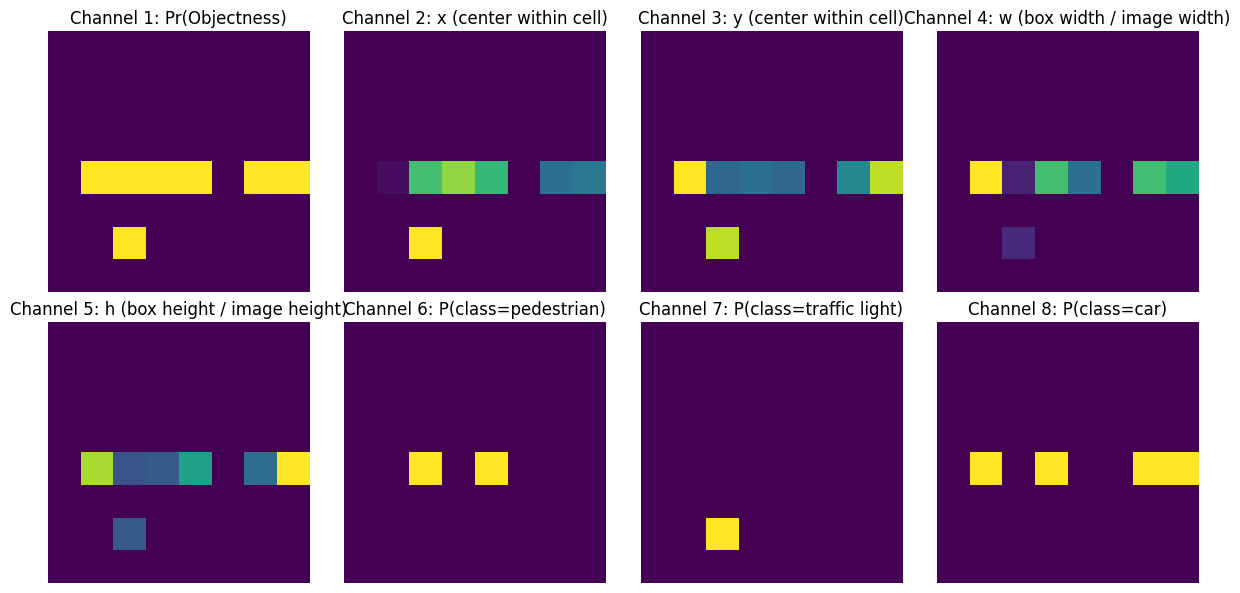

In [36]:
# Visualize the 8x8x8 representation.
import numpy as np
import matplotlib.pyplot as plt

enc = process_labels([raw_labels[SELECT_IDX]])
gt_grid = enc[0]  # (8, 8, 8)

channel_names = [
    "Channel 1: Pr(Objectness)",
    "Channel 2: x (center within cell)",
    "Channel 3: y (center within cell)",
    "Channel 4: w (box width / image width)",
    "Channel 5: h (box height / image height)",
    "Channel 6: P(class=pedestrian)",
    "Channel 7: P(class=traffic light)",
    "Channel 8: P(class=car)",
]

plt.figure(figsize=(12, 6))
for c in range(8):
    plt.subplot(2, 4, c+1)
    plt.imshow(gt_grid[c].T, origin="lower", interpolation="nearest")
    plt.title(channel_names[c])
    plt.axis("off")
plt.tight_layout()
plt.show()


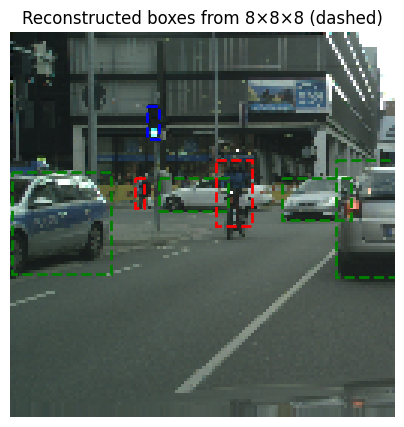

[Round-trip check] GT boxes:   8 | Reconstructed:   7 | Matches (IoU≥0.5, same class):   7
Note: If two GT boxes share a cell, the simplified encoder keeps only the best-fitting one by design.


In [37]:
# Convert back to the original representation (test cases below should pass).
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

recon_list = reconstruct_raw_labels(gt_grid[None, ...], include_score=True)
recon = recon_list[0]  # (N,6): cls, score, x1, y1, x2, y2


plt.figure(figsize=(5,5))
ax = plt.gca()
ax.imshow(img)
if recon.size > 0:
    for row in recon:
        cls, score, x1, y1, x2, y2 = row
        cls = int(cls)
        color = class_to_color.get(cls, "yellow")
        rect = Rectangle((x1, y1), x2-x1, y2-y1, fill=False, linewidth=2, edgecolor=color, linestyle="--")
        ax.add_patch(rect)
ax.set_title("Reconstructed boxes from 8×8×8 (dashed)")
ax.axis("off")
plt.show()

# FIXME Kidus: Removing this + changing reference as it is same as iou_xyxy and iou_xyxy_np
def _iou(a, b):
    ax1, ay1, ax2, ay2 = a
    bx1, by1, bx2, by2 = b
    ix1, iy1 = max(ax1, bx1), max(ay1, by1)
    ix2, iy2 = min(ax2, bx2), min(ay2, by2)
    iw, ih = max(0, ix2-ix1), max(0, iy2-iy1)
    inter = iw*ih
    area_a = max(0, ax2-ax1) * max(0, ay2-ay1)
    area_b = max(0, bx2-bx1) * max(0, by2-by1)
    denom = area_a + area_b - inter
    return inter / denom if denom > 0 else 0.0

gt = gt_boxes
rc = recon[:, [0,2,3,4,5]].astype(np.float32) if recon.size else np.zeros((0,5), np.float32)

matched = 0
used = set()
for g in gt:
    gcls, gx1, gy1, gx2, gy2 = int(_norm_class_id(g[0])), *g[1:]
    best_iou, best_j = 0.0, -1
    for j, r in enumerate(rc):
        if j in used:
            continue
        rcls, rx1, ry1, rx2, ry2 = int(r[0]), *r[1:]
        if rcls != gcls:
            continue
        iou = _iou((gx1,gy1,gx2,gy2), (rx1,ry1,rx2,ry2))
        if iou > best_iou:
            best_iou, best_j = iou, j
    if best_iou >= 0.5 and best_j >= 0:
        matched += 1
        used.add(best_j)

print(f"[Round-trip check] GT boxes: {len(gt):3d} | Reconstructed: {len(rc):3d} | Matches (IoU≥0.5, same class): {matched:3d}")
print("Note: If two GT boxes share a cell, the simplified encoder keeps only the best-fitting one by design.")


2. Implement the loss function. (3%)

3. Make block diagram of requested architecture. Label the diagram with the parts of your code which implement each component. Explain any deviations you made from the described architecture. (15%)

4. Show a plot of the loss over training for your model. (Raw Tensorboard output is not sufficient) (10%)

In [ ]:
# Setup your training
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from typing import Tuple
from torch.optim import Adam


pl.seed_everything(42)

grid_labels = process_labels(raw_labels)           # np.ndarray [N, 8, 8, 8]

# ---------- Dataset ----------
class YoloNPZDataset(Dataset):
    """
    Returns:
      image: torch.float32 [3, 128, 128] in [0,1]
      target: torch.float32 [8, 8, 8]   (channels, x, y)
    """
    def __init__(self, images_np: np.ndarray, grid_labels_np: np.ndarray):
        assert images_np.shape[0] == grid_labels_np.shape[0]
        self.images = images_np
        self.targets = grid_labels_np

    def __len__(self) -> int:
        return self.images.shape[0]

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        img = self.images[idx]
        # to CHW, float32 in [0,1]
        if img.ndim == 3 and img.shape[0] == 3:
            img = np.transpose(img, (1, 2, 0))
        img = img.astype(np.float32) / 255.0
        img = np.transpose(img, (2, 0, 1))  # HWC -> CHW
        img_t = torch.from_numpy(img)

        tgt = self.targets[idx].astype(np.float32)
        tgt_t = torch.from_numpy(tgt)       # [8, 8, 8]
        return img_t, tgt_t

full_ds = YoloNPZDataset(images, grid_labels)

N = len(full_ds)
val_frac = 0.1
val_len = int(N * val_frac)
train_len = N - val_len
train_ds, val_ds = random_split(full_ds, [train_len, val_len],
                                generator=torch.Generator().manual_seed(42))

BATCH_SIZE = 64
NUM_WORKERS = 0  # Set to 0 to avoid multiprocessing issues in Jupyter notebooks

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)

model = YOLO(img_dim=128, grid_size=8, lr=1e-3)  # Start with 1e-3, scheduler will reduce if needed

class LossHistory(pl.Callback):
    def __init__(self):
        super().__init__()
        self.train_loss = []
        self.val_loss = []

    def on_train_epoch_end(self, trainer, pl_module):
        tl = trainer.callback_metrics.get("train_loss_epoch")
        if tl is not None:
            self.train_loss.append(float(tl.detach().cpu()))

    def on_validation_epoch_end(self, trainer, pl_module):
        vl = trainer.callback_metrics.get("val_loss")
        if vl is not None:
            self.val_loss.append(float(vl.detach().cpu()))

loss_hist = LossHistory()

max_epochs = 50  # Increased from 20 - more epochs for better convergence
trainer = pl.Trainer(
    max_epochs=max_epochs,
    accelerator="auto",
    devices="auto",
    log_every_n_steps=25,
    callbacks=[loss_hist],
    enable_progress_bar=True,
    gradient_clip_val=1.0,  # Add gradient clipping for stability
)


INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [39]:
import torch
from torch.utils.data import DataLoader
import pytorch_lightning as pl

@torch.no_grad()
def run_eval_and_decode(model, dataset, indices, batch_size=64, img_dim=128):
    """
    Returns (preds, gts) lists for mAP:
      preds[i]: (Ni,6) [cls, score, x1,y1,x2,y2]
      gts[i]:   (Mi,5) [cls, x1,y1,x2,y2]
    """
    model.eval()
    device = next(model.parameters()).device

    sub_imgs = []
    sub_gts  = []
    for idx in indices:
        img_np, tgt_grid = dataset[idx]
        sub_imgs.append(img_np.numpy())
        gtb = reconstruct_raw_labels(tgt_grid.unsqueeze(0).numpy(), include_score=False)[0]
        sub_gts.append(gtb)

    imgs = torch.from_numpy(np.stack(sub_imgs, 0)).to(device)  # [N,3,128,128]
    preds = []

    for b0 in range(0, imgs.shape[0], batch_size):
        b1 = min(b0 + batch_size, imgs.shape[0])
        out = model(imgs[b0:b1])             # [B,8,8,8] (C,H,W) where H=y, W=x
        out_np = out.detach().cpu().numpy()
        for i in range(out_np.shape[0]):
            g_xy = np.transpose(out_np[i], (0, 2, 1))[None, ...]
            # Always decode all cells, then lightly filter and NMS
            all_decoded = decode_all_cells_consistent(g_xy, img_dim=img_dim)
            # keep very low scores to allow recall early in training
            all_kept = low_confidence_suppression(all_decoded, thresh=0.01)
            nms_kept = non_max_suppression(all_kept, iou_thresh=0.5)
            preds.append(nms_kept)

    return preds, sub_gts

class MAPHistory(pl.Callback):
    def __init__(self, eval_dataset, eval_indices=None):
        super().__init__()
        self.eval_dataset = eval_dataset
        if eval_indices is None:
            n = len(eval_dataset)
            m = min(128, n)
            rng = np.random.default_rng(0)
            self.eval_indices = rng.choice(n, size=m, replace=False).tolist()
        else:
            self.eval_indices = list(eval_indices)
        self.map_values = []

    def on_validation_epoch_end(self, trainer, pl_module):
        preds, gts = run_eval_and_decode(pl_module, self.eval_dataset, self.eval_indices)
        m05 = mean_average_precision(preds, gts, iou_thresh=0.5, classes=(0,1,2))
        m03 = mean_average_precision(preds, gts, iou_thresh=0.3, classes=(0,1,2))
        # Track the more sensitive metric for the line plot
        self.map_values.append(float(m03))
        # Log both
        pl_module.log("mAP@0.5", float(m05), prog_bar=True, on_epoch=True, logger=True)
        pl_module.log("mAP@0.3", float(m03), prog_bar=False, on_epoch=True, logger=True)


In [40]:
import numpy as np

# Helper: stable softmax for numpy arrays
def _softmax_np(x):
    x = np.asarray(x, dtype=np.float32)
    x = x - np.max(x)
    ex = np.exp(x)
    return ex / np.maximum(ex.sum(), 1e-9)

# Decode every cell (no filtering) to boxes with scores
# Returns (N,6): [cls, score, x1, y1, x2, y2]

def decode_all_cells_consistent(grid_np, img_dim=128):
    S = 8
    CELL = img_dim // S
    g = grid_np[0]  # (8,8,8)
    out = []
    for gx in range(S):
        for gy in range(S):
            pr  = float(1.0 / (1.0 + np.exp(-g[0, gx, gy])))
            xr  = float(g[1, gx, gy])
            yr  = float(g[2, gx, gy])
            wr  = max(0.0, float(g[3, gx, gy]))
            hr  = max(0.0, float(g[4, gx, gy]))
            cls_logits = g[5:8, gx, gy]
            cls_probs  = _softmax_np(cls_logits)
            cls = int(np.argmax(cls_probs))
            score = pr * float(cls_probs[cls])
            cx = (gx + xr) * CELL
            cy = (gy + yr) * CELL
            w  = wr * img_dim
            h  = hr * img_dim
            x1 = float(np.clip(cx - 0.5*w, 0, img_dim))
            y1 = float(np.clip(cy - 0.5*h, 0, img_dim))
            x2 = float(np.clip(cx + 0.5*w, 0, img_dim))
            y2 = float(np.clip(cy + 0.5*h, 0, img_dim))
            out.append([cls, score, x1, y1, x2, y2])
    return np.array(out, dtype=np.float32)

# Step-1 post-processing: keep cells with sufficient objectness
# Expects grid_np shaped as (1, 8, 8, 8) with (C, x, y) order in the inner array
# Returns boxes (N,6): [cls, score, x1, y1, x2, y2]

def low_objectness_filter(grid_np, pr_thresh=0.6, img_dim=128):
    S = 8
    CELL = img_dim // S
    g = grid_np[0]
    kept = []
    for gx in range(S):
        for gy in range(S):
            pr  = float(1.0 / (1.0 + np.exp(-g[0, gx, gy])))  # sigmoid -> probability
            if pr < float(pr_thresh):
                continue

            xr  = float(g[1, gx, gy])
            yr  = float(g[2, gx, gy])
            wr  = max(0.0, float(g[3, gx, gy]))
            hr  = max(0.0, float(g[4, gx, gy]))

            # class probs from logits
            cls_logits = g[5:8, gx, gy]
            cls_probs  = _softmax_np(cls_logits)
            cls = int(np.argmax(cls_probs))
            score = pr * float(cls_probs[cls])

            # decode to image coords
            cx = (gx + xr) * CELL
            cy = (gy + yr) * CELL
            w  = wr * img_dim
            h  = hr * img_dim

            x1 = float(np.clip(cx - 0.5*w, 0, img_dim))
            y1 = float(np.clip(cy - 0.5*h, 0, img_dim))
            x2 = float(np.clip(cx + 0.5*w, 0, img_dim))
            y2 = float(np.clip(cy + 0.5*h, 0, img_dim))

            kept.append([cls, score, x1, y1, x2, y2])

    return np.array(kept, dtype=np.float32) if kept else np.zeros((0,6), np.float32)


In [ ]:
# Train your model
# Training on the full dataset.
print("Starting training on full dataset...")
print(f"Training samples: {len(train_ds)}, Validation samples: {len(val_ds)}")

# Reset model for fresh training with improved configuration
model = YOLO(img_dim=128, grid_size=8, lr=1e-3)

# Reset callbacks for full training
loss_hist = LossHistory()
map_hist = MAPHistory(eval_dataset=val_ds)  # Use full validation set for mAP

# Train with full dataset - longer training with all improvements
trainer = pl.Trainer(
    max_epochs=50,  # Increased from 20
    accelerator="auto",
    devices="auto",
    callbacks=[loss_hist, map_hist],
    log_every_n_steps=50,
    check_val_every_n_epoch=1,
    gradient_clip_val=1.0,  # Add gradient clipping
)

print("Training started - this will take a while...")
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)
print("Training completed!")

Starting training on full dataset...
Training samples: 8910, Validation samples: 990


INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | conv1   | Sequential | 1.6 K  | train
1 | conv2   | Sequential | 32.9 K | train
2 | conv3   | Sequential | 131 K  | train
3 | conv4   | Sequential | 524 K  | train
4 | conv5   | Sequential | 2.1 M  | train
5 | conv6   | Sequential | 8.4 M  | train
6 | deconv7 | Sequential | 4.2 M  

Training started - this will take a while...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/tmp/ipython-input-4089863830.py:92: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  ap = float(np.trapz(p, r))


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Training completed!


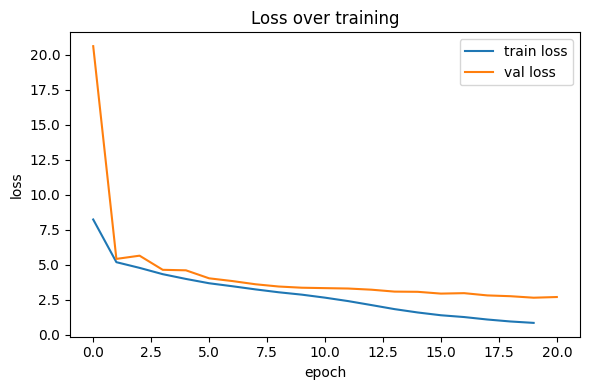

In [42]:
# Plot the results
# After trainer.fit(...)
plt.figure(figsize=(6,4))
plt.plot(loss_hist.train_loss, label="train loss")
plt.plot(loss_hist.val_loss,   label="val loss")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend(); plt.title("Loss over training")
plt.tight_layout(); plt.show()

# DON'T SUBMIT: Test Training on a tiny dataset

In [43]:
# # Small sample subset of dataset training for testing.
# map_hist = MAPHistory(eval_dataset=val_ds)  # evaluate on the val split

# tiny_len = 100
# tiny_ds, _ = random_split(
#     full_ds, [tiny_len, len(full_ds) - tiny_len],
#     generator=torch.Generator().manual_seed(0)
# )
# tiny_train_len = int(0.8 * tiny_len)
# tiny_val_len   = tiny_len - tiny_train_len
# tiny_train, tiny_val = random_split(
#     tiny_ds, [tiny_train_len, tiny_val_len],
#     generator=torch.Generator().manual_seed(0)
# )

# tiny_train_loader = DataLoader(tiny_train, batch_size=4, shuffle=True)
# tiny_val_loader   = DataLoader(tiny_val,   batch_size=1, shuffle=False)
# map_hist = MAPHistory(eval_dataset=tiny_val)

# trainer = pl.Trainer(
#     max_epochs=20,
#     accelerator="auto",
#     devices="auto",
#     callbacks=[loss_hist, map_hist],
# )
# trainer.fit(model, train_dataloaders=tiny_train_loader, val_dataloaders=tiny_val_loader)

# 5. Show a plot of the mean Average Precision over training for your model. (10%)

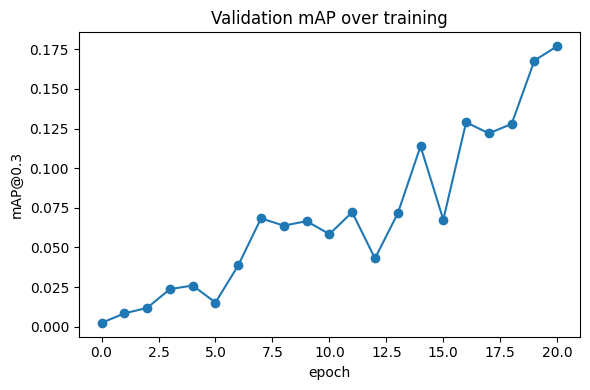

In [44]:
# Optional: plot the more sensitive series we track (mAP@0.3)
plt.figure(figsize=(6,4))
plt.plot(map_hist.map_values, marker="o")
plt.xlabel("epoch"); plt.ylabel("mAP@0.3"); plt.title("Validation mAP over training")
plt.tight_layout(); plt.show()

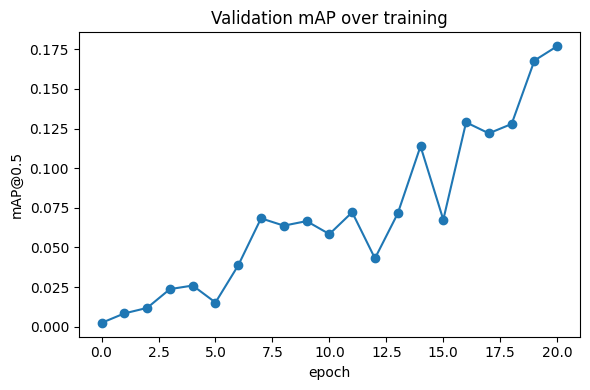

In [45]:


plt.figure(figsize=(6,4))
plt.plot(map_hist.map_values, marker="o")
plt.xlabel("epoch"); plt.ylabel("mAP@0.5"); plt.title("Validation mAP over training")
plt.tight_layout(); plt.show()


6. For one image in the inference step, show the predicted bounding boxes in the image before performing any elimination. Then, show the annotated image after the low probability bounding boxes are removed. Finally, show image after performing non-max suppression. Label each of these visualizations. See Figure 4 as an example of what this visualization should look like. (15%)

In [46]:
import numpy as np

def _softmax_np(x):
    x = np.asarray(x, dtype=np.float32)
    x = x - np.max(x)
    ex = np.exp(x)
    return ex / np.maximum(ex.sum(), 1e-9)

def decode_all_cells_consistent(grid_np, img_dim=128):
    """
    Decode every cell (no filtering), using:
      - Pr := raw channel 0   (NO sigmoid here; keep it consistent with training)
      - class probs := softmax over channels 5..7
      - score := Pr * P(class=argmax)
    Returns (N,6): [cls, score, x1,y1,x2,y2]
    """
    S = 8
    CELL = img_dim // S
    g = grid_np[0]  # (8,8,8)
    out = []
    for gx in range(S):
        for gy in range(S):
            pr  = float(1.0 / (1.0 + np.exp(-g[0, gx, gy])))   # sigmoid -> probability
            xr  = float(g[1, gx, gy])
            yr  = float(g[2, gx, gy])
            wr  = max(0.0, float(g[3, gx, gy]))
            hr  = max(0.0, float(g[4, gx, gy]))

            # class probs from logits
            cls_logits = g[5:8, gx, gy]
            cls_probs  = _softmax_np(cls_logits)
            cls = int(np.argmax(cls_probs))
            score = pr * float(cls_probs[cls])           # rank inside each class

            # decode center & size
            cx = (gx + xr) * CELL
            cy = (gy + yr) * CELL
            w  = wr * img_dim
            h  = hr * img_dim

            x1 = float(np.clip(cx - 0.5*w, 0, img_dim))
            y1 = float(np.clip(cy - 0.5*h, 0, img_dim))
            x2 = float(np.clip(cx + 0.5*w, 0, img_dim))
            y2 = float(np.clip(cy + 0.5*h, 0, img_dim))

            out.append([cls, score, x1, y1, x2, y2])
    return np.array(out, dtype=np.float32)

def low_objectness_filter(grid_np, pr_thresh=0.6, img_dim=128):
    """
    Implements Step-1 of the post-processing spec strictly: keep cells with Pr >= threshold,
    where Pr is *channel 1 of the grid output* (raw, no sigmoid).
    Returns boxes (N,6) like decode_all_cells_consistent, but only for kept cells.
    """
    S = 8
    CELL = img_dim // S
    g = grid_np[0]
    kept = []
    for gx in range(S):
        for gy in range(S):
            pr  = float(1.0 / (1.0 + np.exp(-g[0, gx, gy])))   # sigmoid -> probability
            if pr < float(pr_thresh):
                continue

            xr  = float(g[1, gx, gy])
            yr  = float(g[2, gx, gy])
            wr  = max(0.0, float(g[3, gx, gy]))
            hr  = max(0.0, float(g[4, gx, gy]))

            cls_logits = g[5:8, gx, gy]
            cls_probs  = _softmax_np(cls_logits)
            cls = int(np.argmax(cls_probs))
            score = pr * float(cls_probs[cls])

            cx = (gx + xr) * CELL
            cy = (gy + yr) * CELL
            w  = wr * img_dim
            h  = hr * img_dim

            x1 = float(np.clip(cx - 0.5*w, 0, img_dim))
            y1 = float(np.clip(cy - 0.5*h, 0, img_dim))
            x2 = float(np.clip(cx + 0.5*w, 0, img_dim))
            y2 = float(np.clip(cy + 0.5*h, 0, img_dim))

            kept.append([cls, score, x1, y1, x2, y2])

    return np.array(kept, dtype=np.float32) if kept else np.zeros((0,6), np.float32)


In [47]:
model.eval()
img_t, tgt_grid = val_ds[0]  # pick the *same* overfit sample
img_vis = (img_t.numpy().transpose(1,2,0)*255).astype('uint8')

with torch.no_grad():
    grid_pred = model(img_t.unsqueeze(0).to(next(model.parameters()).device)).cpu().numpy()

# Transpose prediction to (C, x, y) for helpers
grid_pred_cxy = np.transpose(grid_pred, (0, 1, 3, 2))

pred_all  = decode_all_cells_consistent(grid_pred_cxy, img_dim=128)
pred_keep = low_objectness_filter(grid_pred_cxy, pr_thresh=0.6, img_dim=128)  # 0.6 per spec
pred_nms  = non_max_suppression(pred_keep, iou_thresh=0.5)

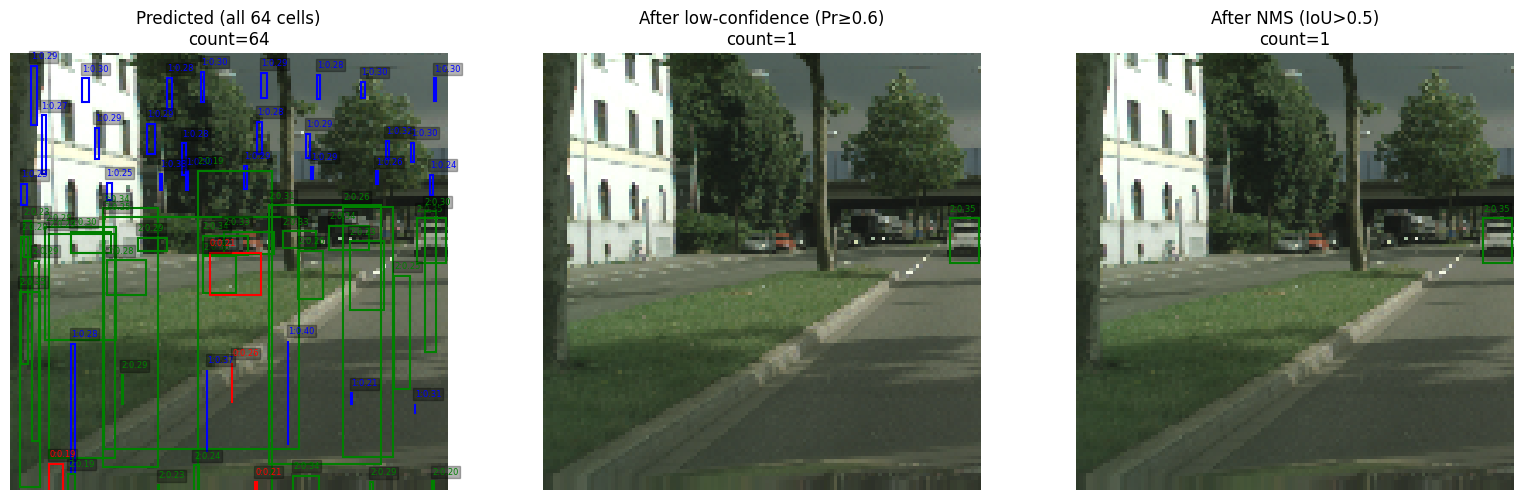

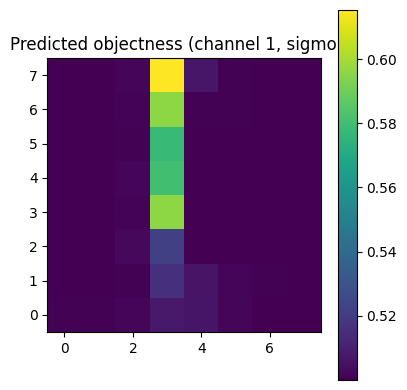

Counts — all: 64, low-conf kept: 1, after NMS: 1
Conf stats — min: 0.187, mean: 0.281, max: 0.397


In [48]:
class_to_color = {0:"red", 1:"blue", 2:"green"}
def draw(ax, img, boxes, title):
    ax.imshow(img); ax.set_title(title); ax.axis("off")
    if boxes is None or boxes.size == 0: return
    for row in boxes:
        cls, score, x1, y1, x2, y2 = row
        color = class_to_color.get(int(cls), "yellow")
        rect = Rectangle((x1,y1), x2-x1, y2-y1, fill=False, linewidth=1.5, edgecolor=color)
        ax.add_patch(rect)
        ax.text(x1, max(0,y1-2), f"{int(cls)}:{score:.2f}", fontsize=6, color=color,
                bbox=dict(facecolor='k', alpha=0.3, pad=1))

plt.figure(figsize=(16,5))
ax1 = plt.subplot(1,3,1); draw(ax1, img_vis, pred_all,  f"Predicted (all 64 cells)\ncount={pred_all.shape[0]}")
ax2 = plt.subplot(1,3,2); draw(ax2, img_vis, pred_keep, f"After low-confidence (Pr≥0.6)\ncount={pred_keep.shape[0]}")
ax3 = plt.subplot(1,3,3); draw(ax3, img_vis, pred_nms,  f"After NMS (IoU>0.5)\ncount={pred_nms.shape[0]}")
plt.tight_layout(); plt.show()

plt.figure(figsize=(4,4))
# Show heatmap using the original (C, H, W)
pred_conf_prob = 1.0 / (1.0 + np.exp(-grid_pred[0, 0]))
plt.imshow(pred_conf_prob.T, origin="lower", interpolation="nearest")
plt.colorbar(); plt.title("Predicted objectness (channel 1, sigmoid)")
plt.tight_layout(); plt.show()

print(f"Counts — all: {pred_all.shape[0]}, low-conf kept: {pred_keep.shape[0]}, after NMS: {pred_nms.shape[0]}")
print(f"Conf stats — min: {pred_all[:,1].min():.3f}, mean: {pred_all[:,1].mean():.3f}, max: {pred_all[:,1].max():.3f}")

7. For one image in the inference step, show the bounding boxes visualized for each class with green bounding boxes around cars, red bounding boxes around pedestrians, and blue bounding boxes around traffic lights as done in Figure 1. Show the precision/recall curves for each class in inference. Write down the achieved mean Average Precision for your inference stage. (17%)

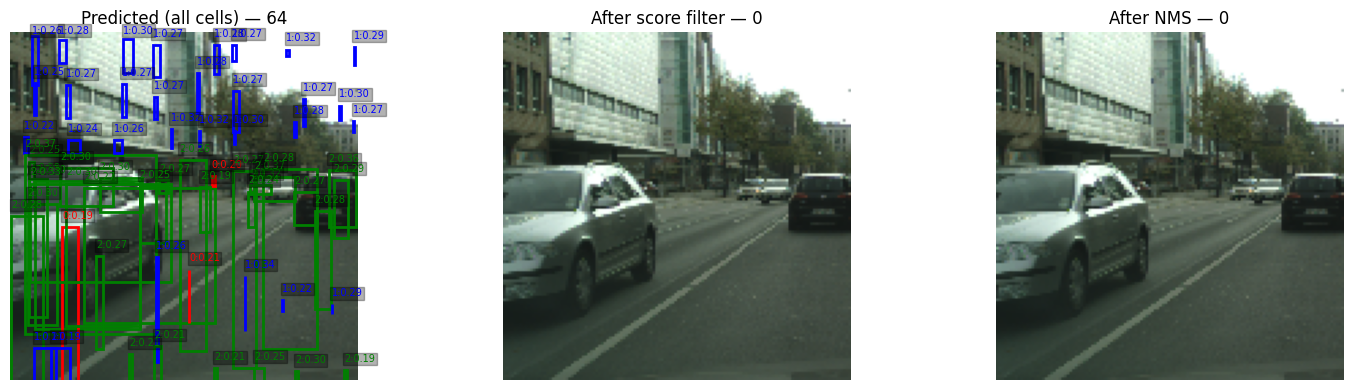

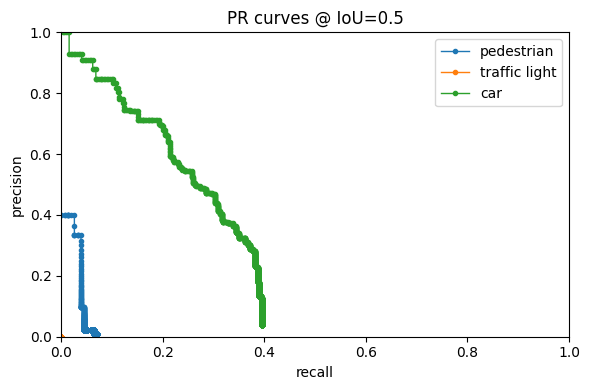

mAP@0.5 on eval set: 0.0879


/tmp/ipython-input-4089863830.py:92: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  ap = float(np.trapz(p, r))


In [56]:
# Inference visualization and PR curves (Task 7)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import torch

# Pick one validation image from the same eval set used for mAP
show_idx = map_hist.eval_indices[2] if hasattr(map_hist, "eval_indices") and len(map_hist.eval_indices) else 0
img_t, tgt_grid = map_hist.eval_dataset[show_idx]
img_vis = (img_t.numpy().transpose(1,2,0) * 255).astype("uint8")

# Forward pass
model.eval()
with torch.no_grad():
    grid_pred = model(img_t.unsqueeze(0).to(next(model.parameters()).device)).cpu().numpy()

# Transpose prediction to (C, x, y) for helpers
grid_pred_cxy = np.transpose(grid_pred, (0, 1, 3, 2))

# Decode + light filtering + NMS
pred_all  = decode_all_cells_consistent(grid_pred_cxy, img_dim=128)
pred_keep = low_confidence_suppression(pred_all, thresh=0.5)
pred_nms  = non_max_suppression(pred_keep, iou_thresh=0.5)

# Color scheme: 0=pedestrian(red), 1=traffic light(blue), 2=car(green)
class_to_color = {0: "red", 1: "blue", 2: "green"}

def draw_preds(ax, img, boxes, title):
    ax.imshow(img); ax.set_title(title); ax.axis("off")
    if boxes is None or boxes.size == 0: return
    for row in boxes:
        cls, score, x1, y1, x2, y2 = row
        color = class_to_color.get(int(cls), "yellow")
        rect = Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, linewidth=2, edgecolor=color)
        ax.add_patch(rect)
        ax.text(x1, max(0, y1 - 3), f"{int(cls)}:{score:.2f}", fontsize=7, color=color,
                bbox=dict(facecolor='k', alpha=0.3, pad=1))

plt.figure(figsize=(15, 4))
ax1 = plt.subplot(1, 3, 1); draw_preds(ax1, img_vis, pred_all,  f"Predicted (all cells) — {pred_all.shape[0]}")
ax2 = plt.subplot(1, 3, 2); draw_preds(ax2, img_vis, pred_keep, f"After score filter — {pred_keep.shape[0]}")
ax3 = plt.subplot(1, 3, 3); draw_preds(ax3, img_vis, pred_nms,  f"After NMS — {pred_nms.shape[0]}")
plt.tight_layout(); plt.show()

# Precision–Recall curves per class and overall mAP@0.5
# Use decode-all + NMS (no score threshold) to avoid empty predictions
_device = next(model.parameters()).device
preds_nt, gts = [], []
for idx in (map_hist.eval_indices if hasattr(map_hist, "eval_indices") else range(len(map_hist.eval_dataset))):
    img_i, tgt_grid_i = map_hist.eval_dataset[idx]
    with torch.no_grad():
        out = model(img_i.unsqueeze(0).to(_device)).cpu().numpy()
    g_xy = np.transpose(out, (0, 1, 3, 2))
    dec = decode_all_cells_consistent(g_xy, img_dim=128)
    nms = non_max_suppression(dec, iou_thresh=0.5)
    preds_nt.append(nms)
    gtb = reconstruct_raw_labels(tgt_grid_i.unsqueeze(0).numpy(), include_score=False)[0]
    gts.append(gtb)

plt.figure(figsize=(6, 4))
for c, name in zip([0, 1, 2], ["pedestrian", "traffic light", "car"]):
    r, p = precision_recall_curve(preds_nt, gts, c, iou_thresh=0.5)
    if r.size and p.size:
        plt.plot(r, p, marker='o', markersize=3, linewidth=1, label=name)
plt.xlim(0, 1); plt.ylim(0, 1)
plt.xlabel("recall"); plt.ylabel("precision"); plt.title("PR curves @ IoU=0.5")
plt.legend(); plt.tight_layout(); plt.show()

m = mean_average_precision(preds_nt, gts, iou_thresh=0.5, classes=(0, 1, 2))
print(f"mAP@0.5 on eval set: {m:.4f}")

8. Explain any issues or challenges you had with your implementation. Explain the performance you achieved and any interesting observations you made while training your network. Discuss hypotheses for how you could improve the performance of your implementation further. (20%)

## Some Useful Online Materials

Original YOLO paper:  
https://arxiv.org/pdf/1506.02640.pdf

Intuitive Explanation:  
https://towardsdatascience.com/yolo-you-only-look-once-real-time-object-detection-explained-492dc9230006

YOLO Video Tutorial:  
https://www.youtube.com/watch?v=9s_FpMpdYW8&list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF&index=30

mean Average Precision:  
https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173

Intersection over Union:  
https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection

## Submission

Make sure you have run all cells in your notebook in order before you zip together your submission, so that all images/graphs appear in the output.

Please submit a pdf file alongside with the notebook, in colab, you can use "File -> Print (Ctrl+P)".

Your submission should include two files: this notebook and the pdf, but not trained model weights.

**Please comment out every training/ploting code, but only keep function definations, please do not modify the signature (name, parameters) of function defination.**

Please save before exporting!